In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import Qobj, destroy, variance, coherent, squeeze, tensor, identity, basis, wigner
from scipy.optimize import minimize

In [2]:
def H_evo(N):
    a = destroy(N)
    NUM = a.dag()*a
    return (NUM + 1)

def evolution(rho,t):
    # [:] is present in case you input qutip Qobj which does not have defined length
    N = len(rho[:])
    a = destroy(N)
    NUM = a.dag()*a
    H_evo = (NUM + 1) 
    def U_evo(t):
        return (-1j*H_evo*t).expm()
    ro = U_evo(t)*rho*U_evo(t).dag()
    return ro

"Definice funkce pro zavedení ztrát"

def Loss(rho,tr,N):
    a = destroy(N)
    H = tensor(a.dag(),identity(N))*tensor(identity(N),a)-tensor(a,identity(N))*tensor(identity(N),a.dag())
    r=np.arccos(tr)
    # Unitary transformation of a beam splitter
    E = (-r*H).expm()
    # Density matrix of vacuum statae
    ro0 = basis(N,0)*basis(N,0).dag()
    # Two-mode state at the output of the beam splitter
    ro = E*tensor(rho,ro0)*E.dag()
    # Single-mode state in one of the beam splitter's output
    rop = ro.ptrace(0)
    return(rop)

def simulate_lossy_spacs(ampl,phi,tr,N):
    a = destroy(N)
    psi = a.dag()*coherent(N, ampl) # Coherent photon addition
    psi = psi.unit() # State vector normalization
    rho = psi * psi.dag() # Making a density matrix out ouf the state psi
    rho = Loss(rho,tr,N)
    rho = rho[:] # Returning density matrix as an numpy array not Qobj
    rho = evolution(rho,phi) # Free evolution of the state
    return rho

#pomocná vyhodnocovací funkce pro optimalizaci
def nlsqpa_th_v0(l,par):
    l = l[0]
    stav = par[0]
    dim = par[1]
    A = destroy(dim)
    x = (A.dag()+A)/np.sqrt(2)
    p = 1j*(A.dag()-A)/np.sqrt(2)
    return variance(l*p - x**2 / np.sqrt(2)/l**2,stav)/(3/4)

# This
#funkce vyčíslující nelineární stlačení pro stav, input: stav, dimenze Fockova prostoru
def nlsq_th(stav,dim):
    return minimize(nlsqpa_th_v0,1.13,args=[stav,dim]).fun

#funkce hledající minimum wignerovi funkce pro čistý spac stav
def find_wig_min(alpha,tr):
    N = 2
    rho = Qobj(simulate_lossy_spacs(-alpha*1j,0,tr, N=dim))
    # Sampling the whole Hilbert space
    samples = np.linspace(-N,N,300)
    x, p = np.meshgrid(samples, samples) 
    # Computing the Wigner function of the state
    Wig_res = wigner(rho,samples,samples)
    return np.min(Wig_res)

In [3]:
dim = 25
alpha = 1.431

List_of_transmittances = np.round(np.arange(0.50,1.0,.01),2)

List_of_lossy_states_spacs = [nlsq_th(Qobj(simulate_lossy_spacs(-alpha*1j,0,tr, N=dim)),dim) for tr in List_of_transmittances]
List_of_lossy_states_spacs = np.array(List_of_lossy_states_spacs)
List_of_wigners_mins = [find_wig_min(alpha,tr) for tr in List_of_transmittances]

<IPython.core.display.Javascript object>


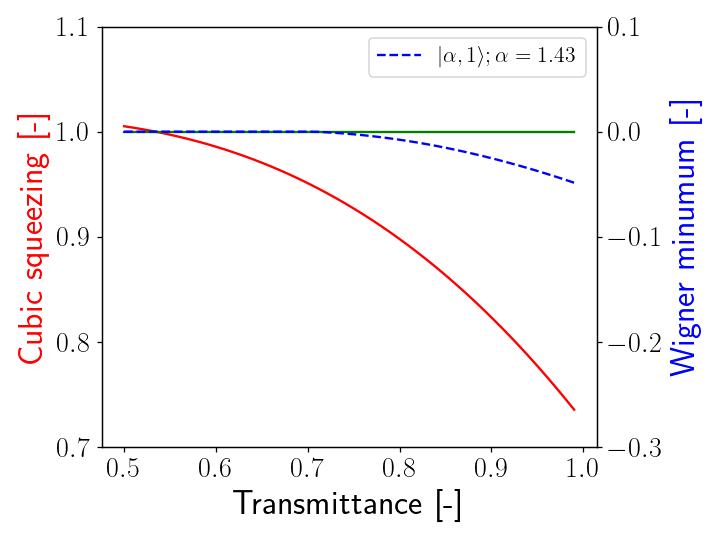

In [4]:
fontsize = 18
dpi = 300
plt.rcParams['text.usetex'] = True
%matplotlib notebook
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(List_of_transmittances,List_of_lossy_states_spacs,'r-',label = r"$\alpha = 1.43$")
ax2.plot(List_of_transmittances, List_of_wigners_mins, 'b--',label = r"$\vert \alpha, 1 \rangle; \alpha = 1.43$")
ax1.plot(List_of_transmittances,np.ones(len(List_of_transmittances)),"g-",label = "threshold")

# ax1.set_xlabel('Transmittance losses [-]',fontsize = fontsize, labelsize=fontsize)
# ax1.set_ylabel('Nonlinear squeezing [-]',fontsize = fontsize, color='r')
# ax2.set_ylabel('Wigner minumum [-]',fontsize = fontsize, color='b')
# ax1.tick_params(labelsize=fontsize)
# ax2.tick_params(labelsize=fontsize)

ax1.tick_params('x', labelsize=fontsize)
ax1.tick_params('y', labelsize=fontsize)
ax2.tick_params('y', labelsize=fontsize)
ax1.set_ylabel('Cubic squeezing [-]', fontsize=fontsize+4,color='r')
ax2.set_ylabel('Wigner minumum [-]', fontsize=fontsize+4, color='b')
ax1.set_xlabel('Transmittance [-]', fontsize=fontsize+4)

ax1.set_ylim([0.7,1.1])
ax2.set_ylim([-0.3,0.1])
ax1.set_xticks([0.5,0.6,0.7,0.8,0.9,1])
plt.legend(fontsize=fontsize-4)
plt.tight_layout()
plt.rcParams['text.usetex'] = False
#plt.savefig(f'Figure 6.png', dpi=dpi,bbox_inches='tight')